# Predictive Maintenance

Este notebook contém o trabalho final da disciplina de Estatística II para a turma #970 LM Tech Data Talents do curso de Python e Dados da Ada Tech dos alunos:
* Claudia Cavalcante Fonseca 
* Hevans Vinícius Pereira
* Lucas Voltolini
* Renato Massamitsu Zama Inomata
* Vitor Cunha Cavalcanti Manso
* William James Erthal

## BASE DE DADOS

Vamos trabalhar com o dataset [Machine Predictive Maintenance](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification?resource=download) para prever falhas em máquinas, este contém dados fictícios sobre manutenção de máquinas em uma indústria.

Esse dataset pode ser usado para a criação de modelos que prevêem que máquinas apresentarão um problema e precisarão de manutenção (classificação binária) e também pode ser usado para a criação de modelos que prevêem o tipo de erro que ocorre (classificação multiclasse).

O dataset possui 10 000 registros e 14 colunas:
* **UID**: Identificador único das máquinas

* **product ID**: A qualidade do produto que a máquina produz, que pode ser baixa(L, 50% dos produtos), média (M, 30% dos produtos) ou alta (H, 20% dos produtos) e um número de série específico para essa variante.

* **Type**: Apenas o tipo do produto, sem o ID.

* **air temperature [K]**: Indica a temperatura do ar e varia de 2K a 300K.

* **process temperature [K]**: A medida da temperatura durante o processo de fabricação ou operação. 

* **rotational speed [rpm]**: A velocidade de rotação da máquina.
* **torque [Nm]**: Uma medida da força de rotação aplicada pela máquina, expressa em Newton metros (Nm). 

* **tool wear [min]**:  O desgaste da ferramenta é uma medida do tempo acumulado de uso da ferramenta durante o processo de fabricação ou operação, expresso em minutos. O desgaste da ferramenta aumenta gradualmente à medida que a máquina é utilizada, sendo influenciado pela variante de qualidade do produto.


Neste trabalho iremos focar na detecção de binária de ocorrência de falha.

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
#import gdown

In [ ]:
# Função pra criar a matriz de confusão
def matriz_confusao(y_test, y_pred):
    matriz = confusion_matrix(y_test, y_pred)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    fig.suptitle('Matriz de Confusão', y=1.1)
    # criando mapa de calor com valores absolutos
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Valores Preditos')
    ax1.set_ylabel('Valores Observados')

    # criando mapa de calor com valores relativos
    sns.heatmap(matriz / np.sum(matriz), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
    ax2.set_xlabel('Valores Preditos')
    ax2.set_ylabel('Valores Observados')
    fig.tight_layout()

In [ ]:
# Função para criar a curva ROC e calcular a área abaixo da curva
def curva_roc(y_test, y_pred, modelo):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, modelo.predict_proba(X_test)[:,1])
    plt.figure(figsize=(4,2))
    plt.plot(fpr, tpr, label=f'(área = {round(logit_roc_auc, 2)})')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend(loc="lower right");

In [ ]:
# importando dados
df = pd.read_csv('predictive_maintenance.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


# Análise Exploratória de Dados

Vamos renomear as colunas para facilitar o trabalho.

In [ ]:
df.columns = ['udi','product_id','type','air_temperature','process_temperature',
              'rotational_speed','torque','tool_wear', 'target', 'failure_type']

In [ ]:
# analisando tipos das variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   udi                  10000 non-null  int64  
 1   product_id           10000 non-null  object 
 2   type                 10000 non-null  object 
 3   air_temperature      10000 non-null  float64
 4   process_temperature  10000 non-null  float64
 5   rotational_speed     10000 non-null  int64  
 6   torque               10000 non-null  float64
 7   tool_wear            10000 non-null  int64  
 8   target               10000 non-null  int64  
 9   failure_type         10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


Podemos observar que há variáveis numéricas do tipo inteiro e float e algumas que contém texto, perfazendo um total de 10.000 observações.

In [ ]:
# verificando dados nulos
df.isnull().sum()

udi                    0
product_id             0
type                   0
air_temperature        0
process_temperature    0
rotational_speed       0
torque                 0
tool_wear              0
target                 0
failure_type           0
dtype: int64

In [ ]:
# obtendo estatísticas descritivas
df.describe()

,udi,air_temperature,process_temperature,rotational_speed,torque,tool_wear,target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


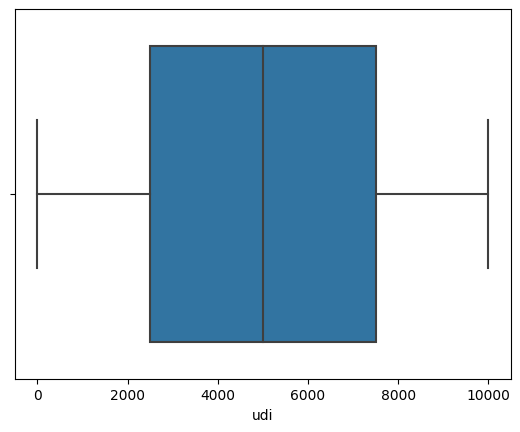

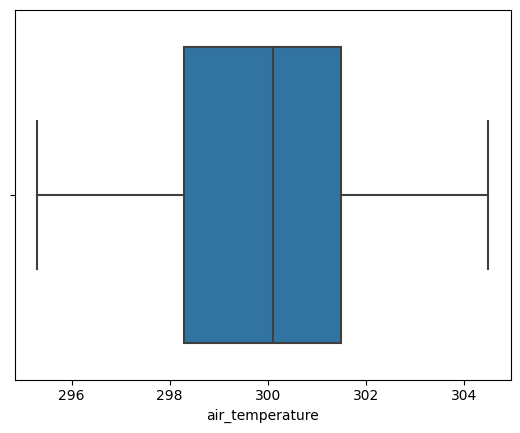

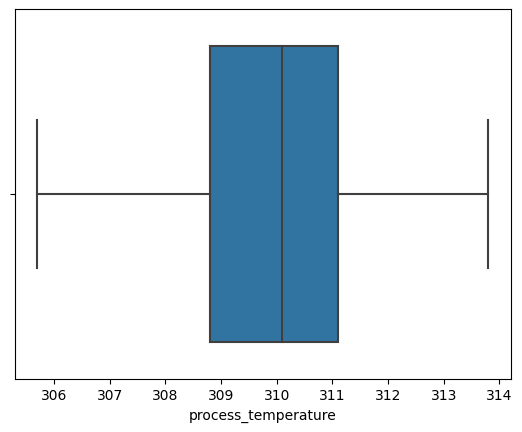

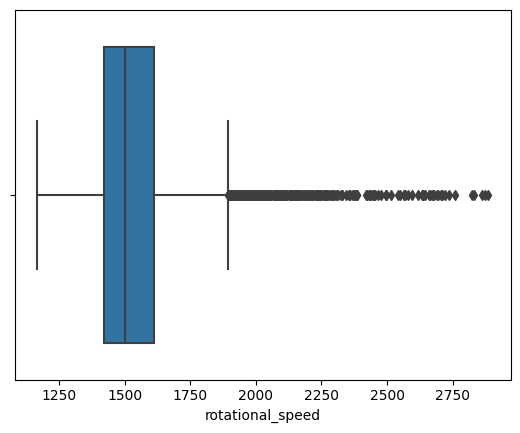

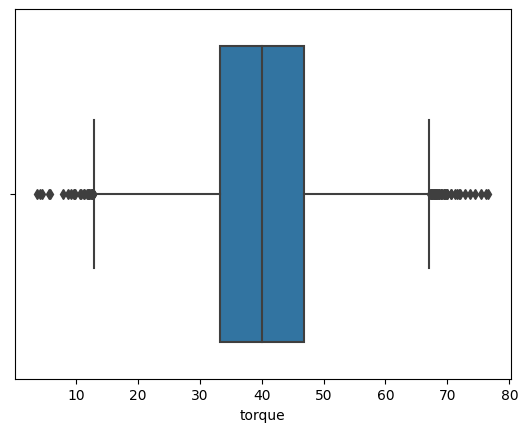

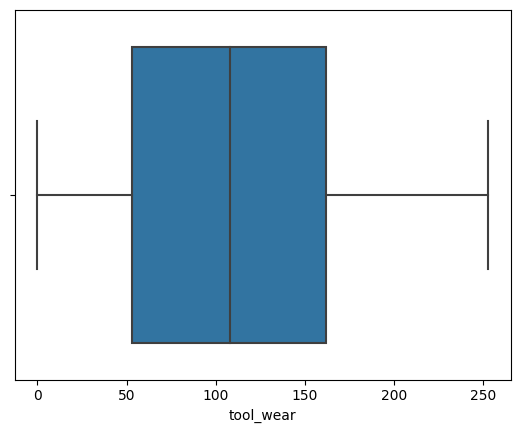

In [ ]:
for col in df.select_dtypes(include=[np.number]).columns[:-1]:
    sns.boxplot(df, x=col)
    plt.show()

Não há dados faltantes. Agora, vamos analisar as colunas `target` e `failure_type`.

In [ ]:
df["target"].value_counts()

0    9661
1     339
Name: target, dtype: int64

In [ ]:
df["failure_type"].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: failure_type, dtype: int64

Analisando as quantidades totais de erros, parece haver algumas inconsistências no conjunto de dados.

Vamos verificar se a coluna `target` aponta que teve falha, mas a coluna `failure_type` aponta que não teve, e vice versa.

In [ ]:
df_erro_falha = df[(df["target"] == 0) & (df["failure_type"] != "No Failure")]
df_erro_falha

,udi,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,target,failure_type
1221,1222,M16081,M,297.0,308.3,1399,46.4,132,0,Random Failures
1302,1303,L48482,L,298.6,309.8,1505,45.7,144,0,Random Failures
1748,1749,H31162,H,298.4,307.7,1626,31.1,166,0,Random Failures
2072,2073,L49252,L,299.6,309.5,1570,35.5,189,0,Random Failures
2559,2560,L49739,L,299.3,309.0,1447,50.4,140,0,Random Failures
3065,3066,M17925,M,300.1,309.2,1687,27.7,95,0,Random Failures
3452,3453,H32866,H,301.6,310.5,1602,32.3,2,0,Random Failures
5471,5472,L52651,L,302.7,312.3,1346,61.2,170,0,Random Failures
5489,5490,L52669,L,302.6,312.1,1499,35.0,215,0,Random Failures
5495,5496,H34909,H,302.9,312.5,1357,55.0,12,0,Random Failures


In [ ]:
df_erro_target = df[(df["target"] == 1) & (df["failure_type"] == "No Failure")]
df_erro_target

,udi,product_id,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,target,failure_type
1437,1438,H30851,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,2750,M17609,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,4045,M18904,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,4685,M19544,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,5537,M20396,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,5942,L53121,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,6479,L53658,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,8507,L55686,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,9016,L56195,L,297.2,308.1,1431,49.7,210,1,No Failure


Como visto acima, todas as 18 vezes que a falha "Random Failures" aparece no dataset, a coluna `target` aponta que não teve falha. Portanto, vamos remover estas linhas, assim como as linhas em que a coluna `target` aponta uma falha erroneamente, pois não são observações confiáveis e não temos como verificar com as pessoas que coletaram esses dados.

In [ ]:
# removendo as observações citadas acima
df_erros = pd.concat([df_erro_falha, df_erro_target])
df.drop(df_erros.index, axis=0, inplace=True)
print(f'Restaram {df.shape[0]} observaões.')

Restaram 9973 observaões.


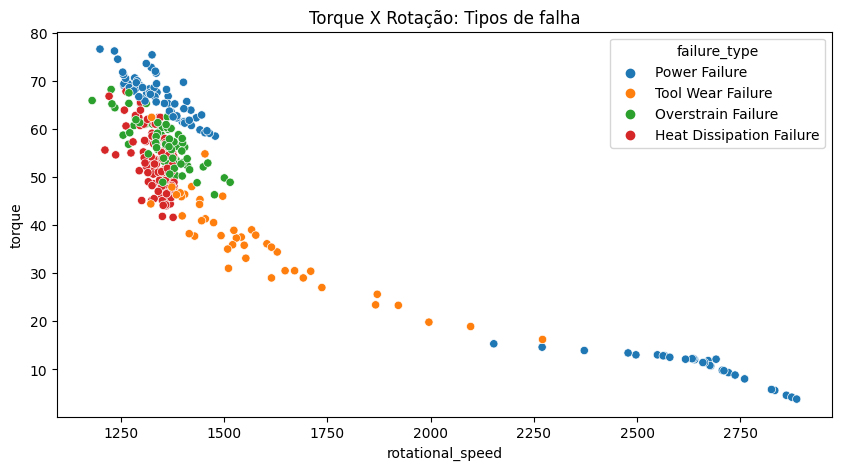

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df[df["target"] == 1], x="rotational_speed", y="torque", hue="failure_type")
plt.title("Torque X Rotação: Tipos de falha")
plt.show()

Pode-se notar que as falhas do tipo "Heat Dissipation Failure" e "Overstrain Failure" possuem um comportamente semelhante entre si no que se refere às variáveis `rotational_speed` e `torque`, mas diferem dos demais tipo de erro.

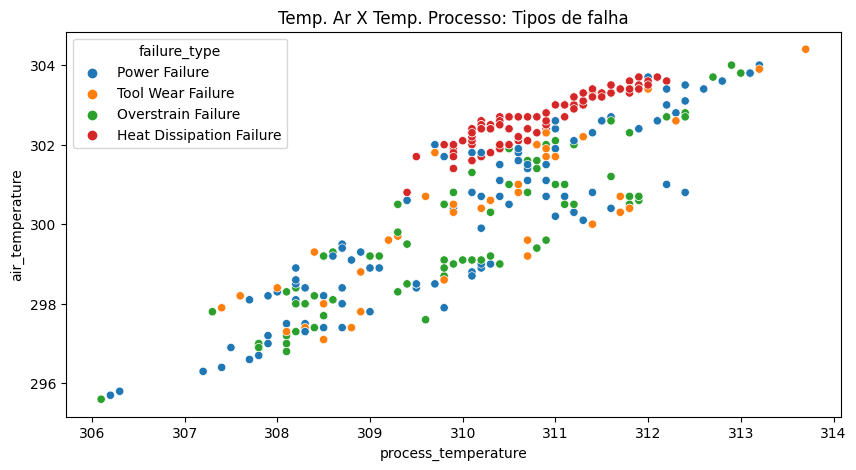

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df[df["target"] == 1], x="process_temperature", y="air_temperature", hue="failure_type")
plt.title("Temp. Ar X Temp. Processo: Tipos de falha")
plt.show()

Agora podemos notar que as falhas do tipo "Heat Dissipation Failure" possuem um comportamente único no que se refere às variáveis `process_temperature` e `air_temperature`.

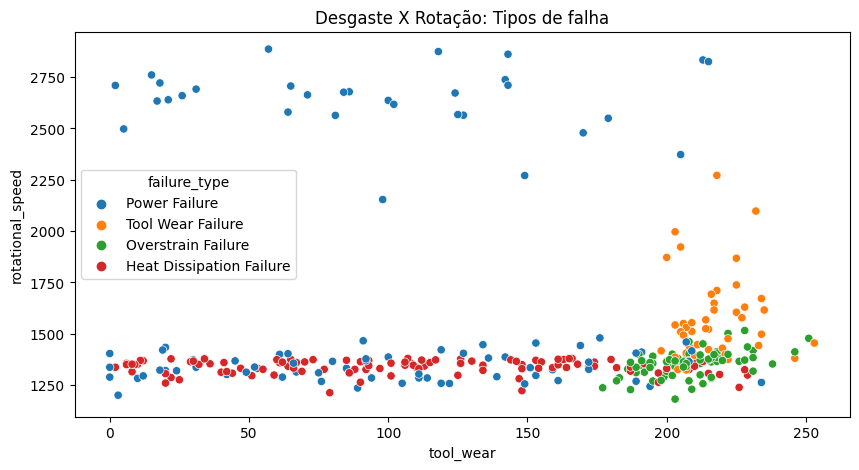

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df[df["target"] == 1], x="tool_wear", y="rotational_speed", hue="failure_type")
plt.title("Desgaste X Rotação: Tipos de falha")
plt.show()

Agora podemos notar que as falhas do tipo "Tool Wear Failure" possuem um comportamente único no que se refere às variáveis `tool_wear` e `rotacional_speed`.

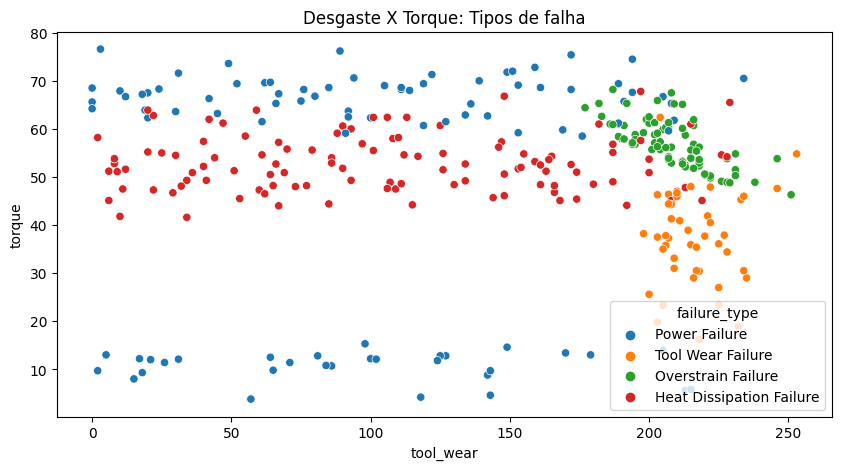

In [ ]:
plt.figure(figsize=(10, 5))
sns.scatterplot(df[df["target"] == 1], x="tool_wear", y="torque", hue="failure_type")
plt.title("Desgaste X Torque: Tipos de falha")
plt.show()

Agora podemos notar que as falhas do tipo "Tool Wear Failure" e "Overstrain Failure" possuem um comportamente semelhante no que se refere às variáveis `tool_wear` e `torque`, mas diferem dos demais tipos de falha.

A seguir, vamos tentar observar se há relação entre a variável `type` que indica a qualidade do produto sendo produzido por máquina e as demais variáveis, levando em consideração a separação por `target`.

In [ ]:
df.columns

Index(['udi', 'product_id', 'type', 'air_temperature', 'process_temperature',
       'rotational_speed', 'torque', 'tool_wear', 'target', 'failure_type'],
      dtype='object')

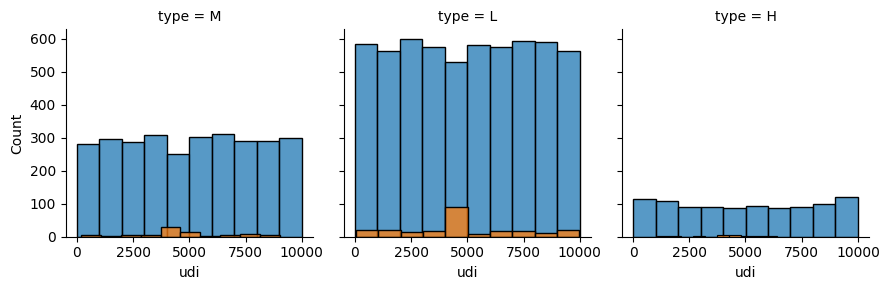

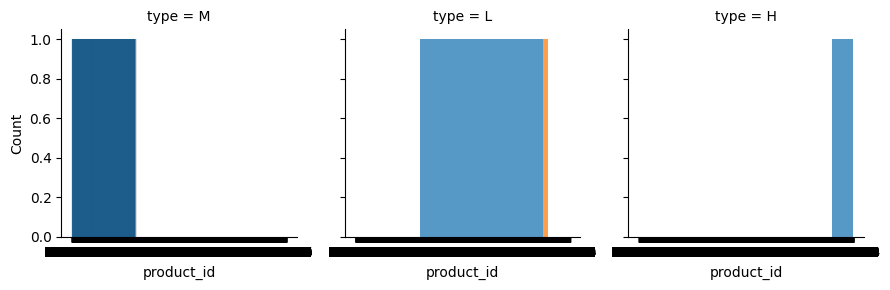

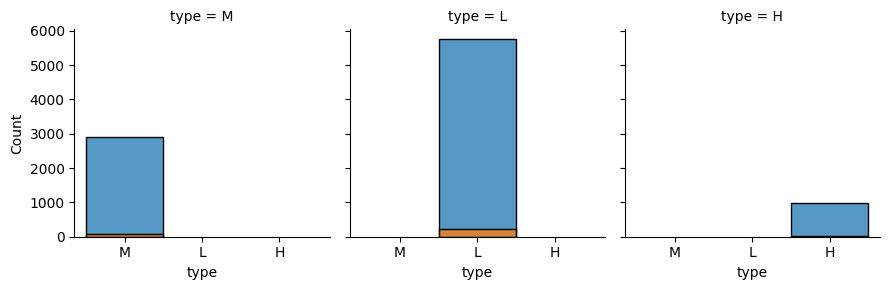

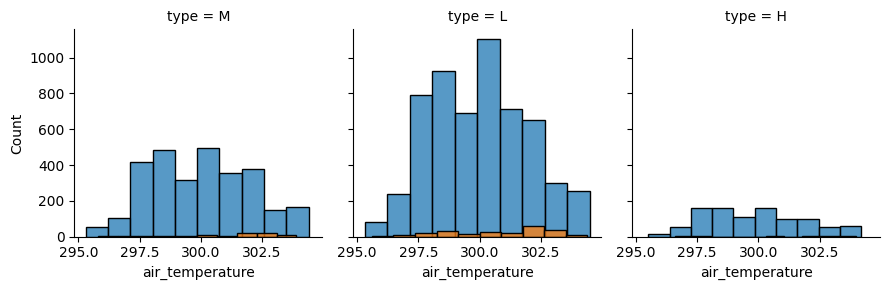

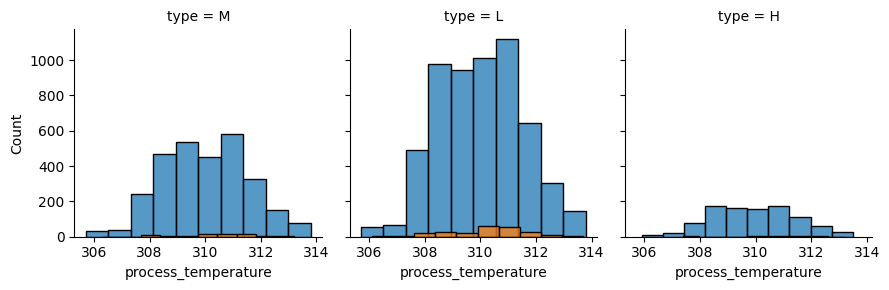

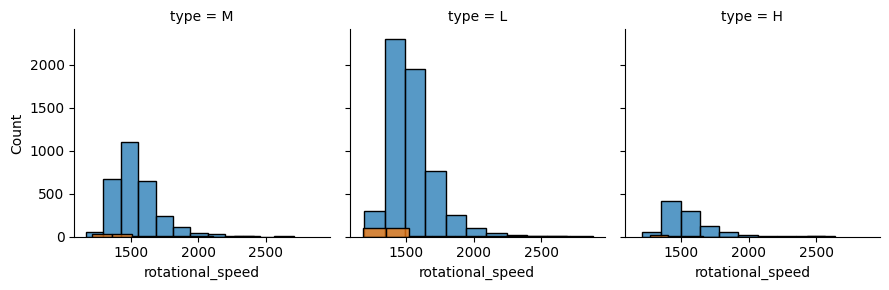

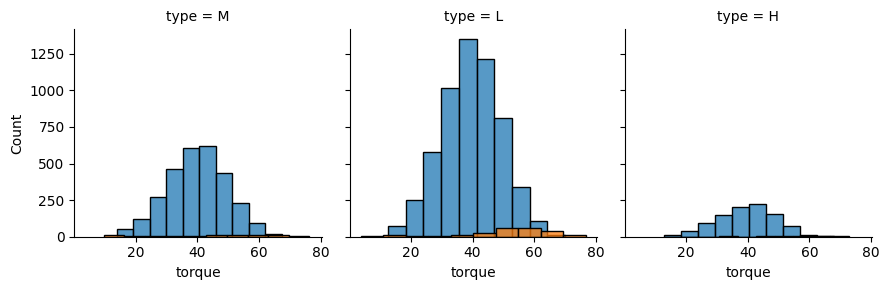

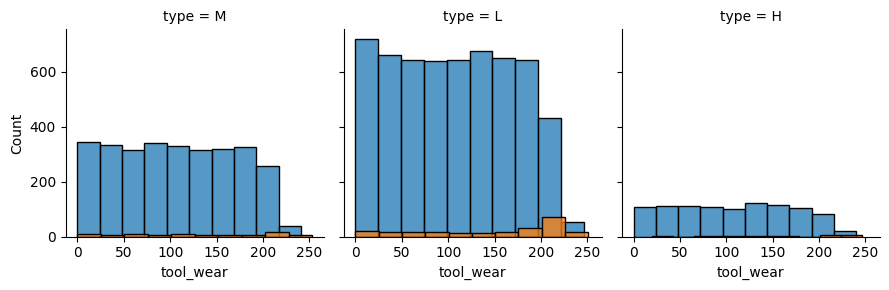

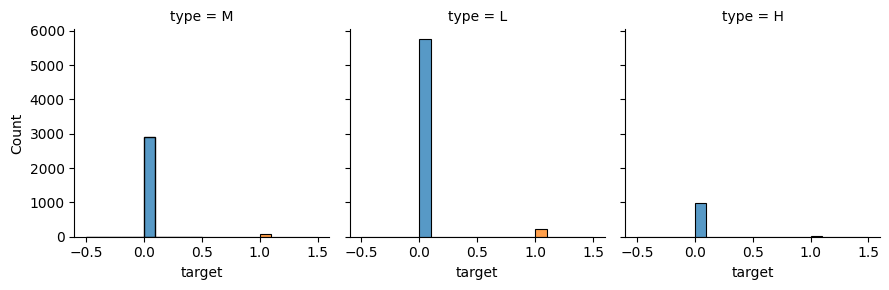

In [ ]:
for col in df.columns[:-1]:
    g = sns.FacetGrid(df.iloc[:,:-1], col="type", hue = 'target')
    g.map(sns.histplot, col, bins = 10)
    plt.show()

 O próximo passo é descartar colunas de identificação que não serão usadas no trabalho, isto é, `udi` e `product_id` que são identificadores que não agregam nenhuma informação relevante para nossos propósitos e a coluna `failure_type` pois usaremos a coluna `target` e ambas possuem informações sobre falhas.

In [ ]:
# descartando colunas desnecessárias
df.drop(['udi','product_id','failure_type'], axis=1, inplace=True)
df.head()

,type,air_temperature,process_temperature,rotational_speed,torque,tool_wear,target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


Precisamos entender melhor e tratar a variável `type`.

In [ ]:
# calculando a porcentagem de observações da variável type
df["type"].value_counts(normalize=True) * 100

L    60.002005
M    29.990976
H    10.007019
Name: type, dtype: float64

A seguir, vamos observar como é a distribuição de cada variável em relação à variável `target`.

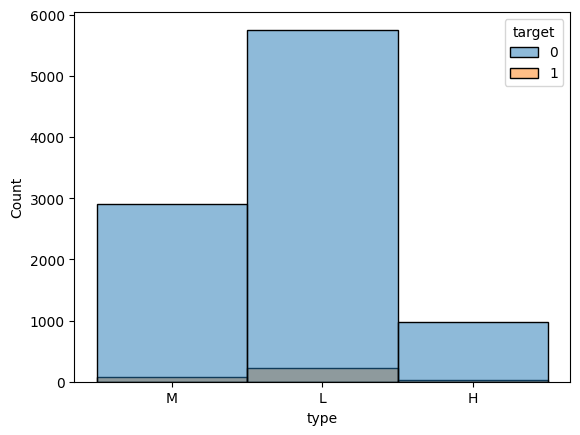

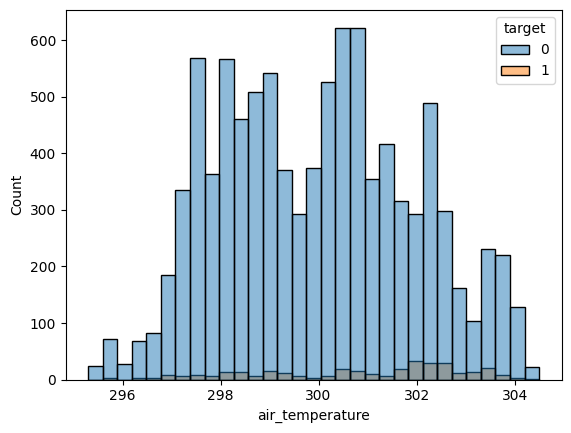

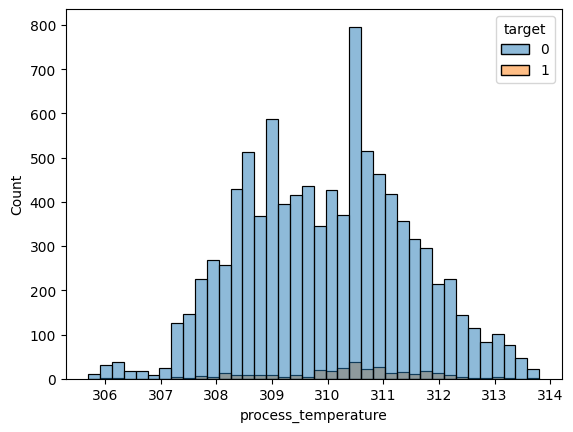

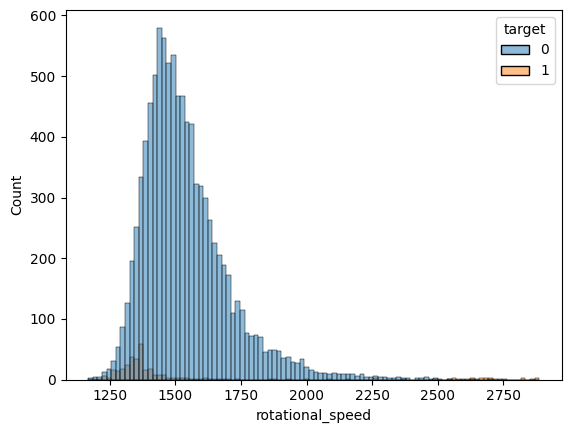

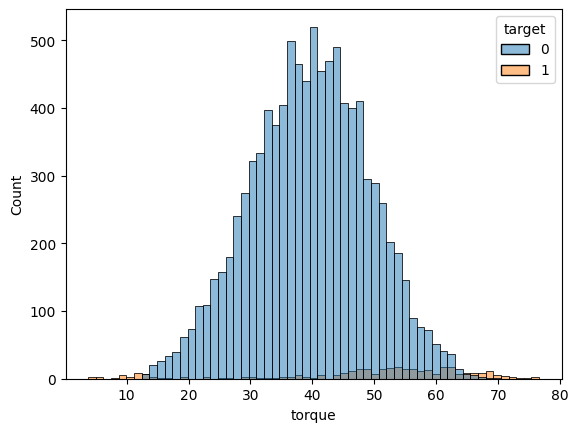

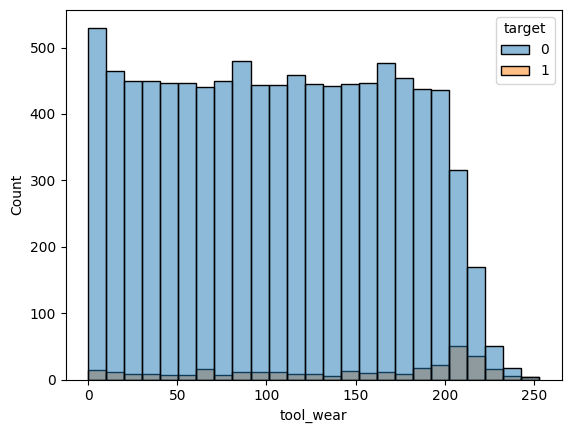

In [ ]:
for col in df.columns[:-1]:
    sns.histplot(df, x = col, hue = 'target')
    plt.show()

Vamos também fazer um pairplot para observar se aparentemente há correlação entre algumas das variáveis.

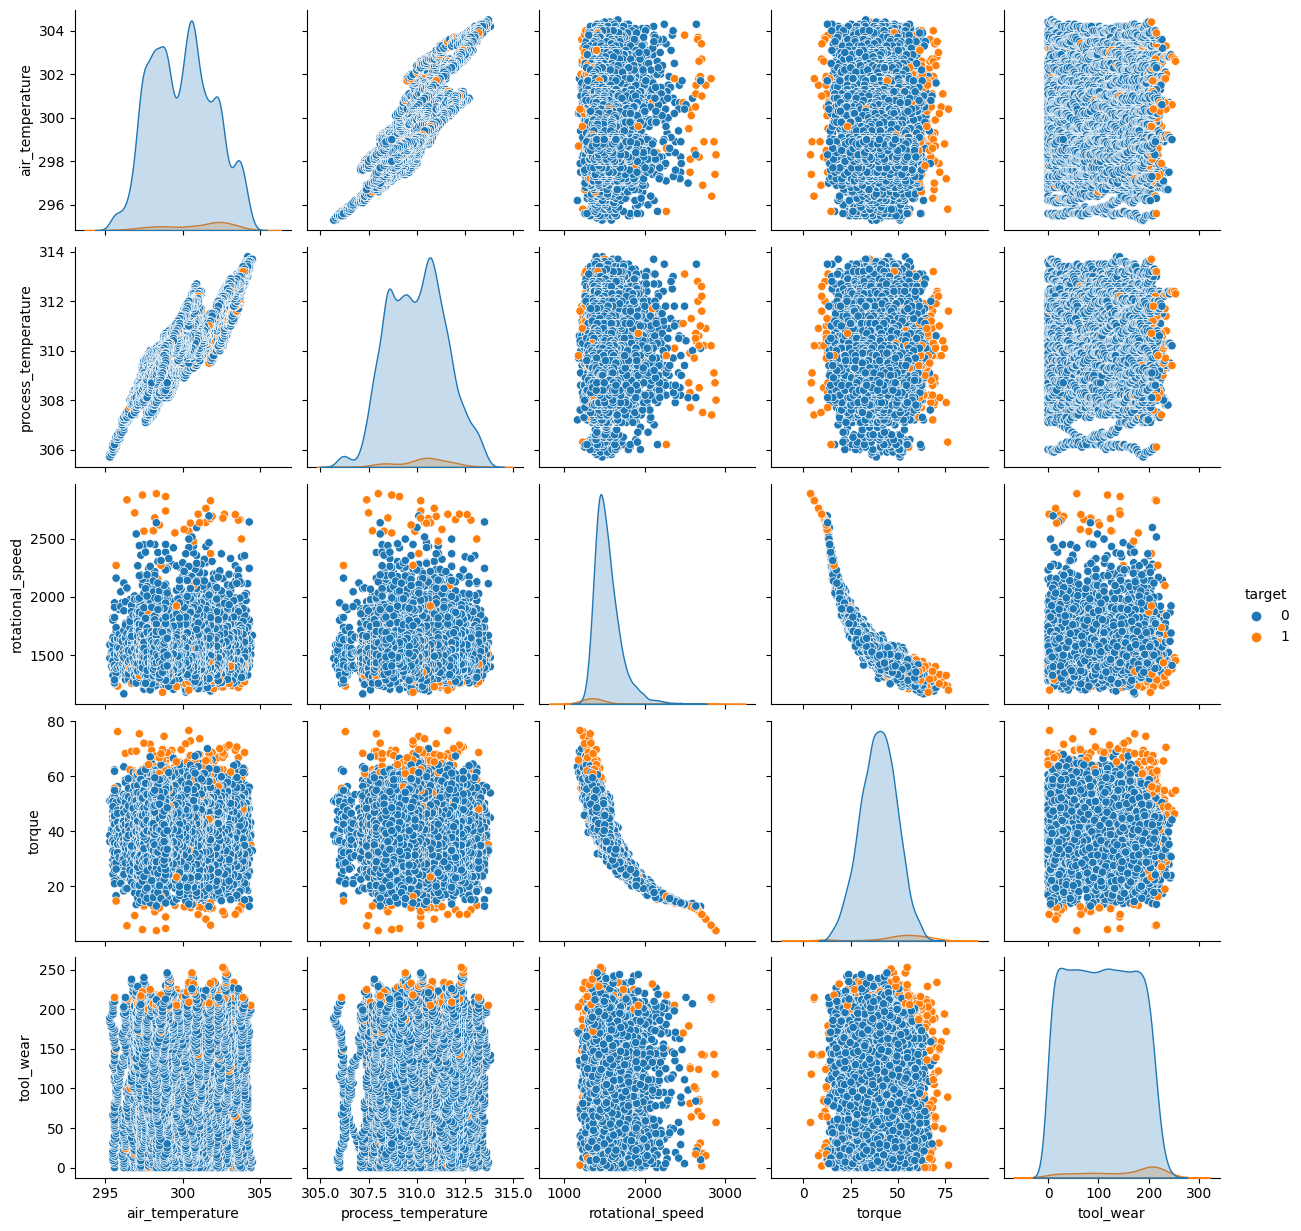

In [ ]:
sns.pairplot(df, hue = 'target');

A quantidade e a dispersão dos pontos não nos permite chegar à uma conclusão, portanto usaremos o cálculo de correlação. Como a variável `target` é categórica e queremos saber se alguma variável está relacionada a ela, usaremos a correlação de Spearman, pois a correlação de Pearson não é indica nesse caso.

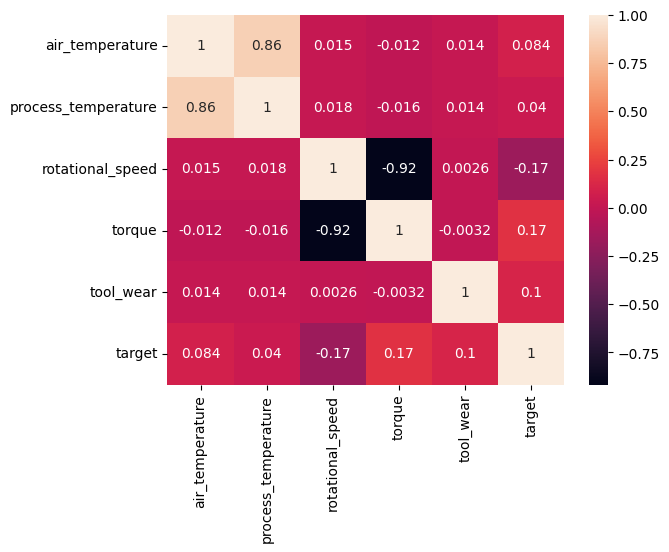

In [ ]:
# calculando correlação entre as variáveis
sns.heatmap(df.corr(method='spearman'), annot=True);

De acordo com a tabela de correlação, nenhuma das variáveis tem forte correlação com a variável `target`, embora `torque` e `rotacional_speed` tenham forte relação negativa. Isso já era esperado, pois $Potência = Torque \times Rotação$ e a potência das máquinas é aproximadamente constante durante o funcionamento.


A potência está diretamente relacionada à taxa de transferência ou conversão de energia. Para identificar falhas de energia ("Power failures"), pode ser interessante considerar a variável potência.

Conversando com a área de negócio (engenharia) vimos que falhas relacionadas à dissipação de calor ("Heat dissipation failure") estão mais relacionadas à diferença entre a temperatura externa e interna do que à temperatura interna propriamente dita. 

Isso se dá porque a lei do resfriamento de Newton estabelece que a taxa de transferência de calor é proporcional à diferença de temperatura entre o objeto e o ambiente. 

Isso sugere fortemente a criação de uma variável que contenha essa informação.

In [ ]:
# criando duas variáveis que podem ser de interesse
df['power'] = df['torque'] * df['rotational_speed']
df['diference_temperature'] = df['air_temperature'] - df['process_temperature']

## Machine Learning

Antes de criar nossos modelos de classificação precisaremos tratar a variável `type` que no momento contém texto, colocar todos os nossos dados na mesma escala e separar em treino e teste.

A seguir vamos usar One Hot Encoding para transformar a variável `type` e excluir uma das colunas criadas para evitar problemas de correlação.

In [ ]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.6 MB/s eta 0:00:00


In [ ]:
# importando bibliotecas
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn import tree
import shap
import pickle

from sklearn.metrics import confusion_matrix, precision_score, classification_report, roc_curve, roc_auc_score, accuracy_score, recall_score

In [ ]:
df = pd.get_dummies(df, columns=["type"], drop_first=True)
df.head()

,air_temperature,process_temperature,rotational_speed,torque,tool_wear,target,power,diference_temperature,type_L,type_M
0,298.1,308.6,1551,42.8,0,0,66382.8,-10.5,0,1
1,298.2,308.7,1408,46.3,3,0,65190.4,-10.5,1,0
2,298.1,308.5,1498,49.4,5,0,74001.2,-10.4,1,0
3,298.2,308.6,1433,39.5,7,0,56603.5,-10.4,1,0
4,298.2,308.7,1408,40.0,9,0,56320.0,-10.5,1,0


In [ ]:
# separando os dados em treino e teste
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

colunas = X_train.columns

Colunas de torque e velocidade de rotação possuem vários outliers, método de escala utilizado será o RobustScaler.

In [ ]:
# escalonando os dados
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=colunas)
X_test = pd.DataFrame(scaler.transform(X_test), columns=colunas)

In [ ]:
# verificando se a variável y está balanceada
y_train.value_counts()

0    6750
1     231
Name: target, dtype: int64

In [ ]:
# verificando se a variável y está balanceada
y_test.value_counts()

0    2893
1      99
Name: target, dtype: int64

### Regressão Logística

Nosso primeiro modelo será a regressão logística, por ser um modelo simples e rápido e que poderemos usar de base em comparação com outros modelos. Usaremos o hiperparâmetros `class_weight='balanced'` pois a variável `target` é desbalanceada.


Usaremos também `RandomizedSearchCV` para fazer o tuning de hiperparâmetros e usar cross validation.

In [ ]:
# instanciando algoritmo
model1 = LogisticRegression(class_weight='balanced', random_state=42)

# criando valores para os hiperparametros
params1 = {'penalty':['l1', 'l2', 'elasticnet', None],
           'C':[1.5,1,0.5,0.01]}

clf1 = RandomizedSearchCV(model1, params1, cv=5, random_state=42, scoring=['recall','f1'], refit='recall')
search1 = clf1.fit(X_train, y_train)

Podemos checar os melhores hiperparâmetros encontrados com `search1.best_params_`

In [ ]:
search1.best_params_

{'penalty': 'l2', 'C': 0.5}

Também podemos obter o melhor modelo com `search1.best_estimator_`

In [ ]:
search1.best_estimator_

LogisticRegression(C=0.5, class_weight='balanced', random_state=42)

Agora podemos fazer previsões com o conjunto de teste e avaliar o modelo.

In [ ]:
clf1 = search1.best_estimator_

# fazendo previões
y_pred1 = search1.predict(X_test)

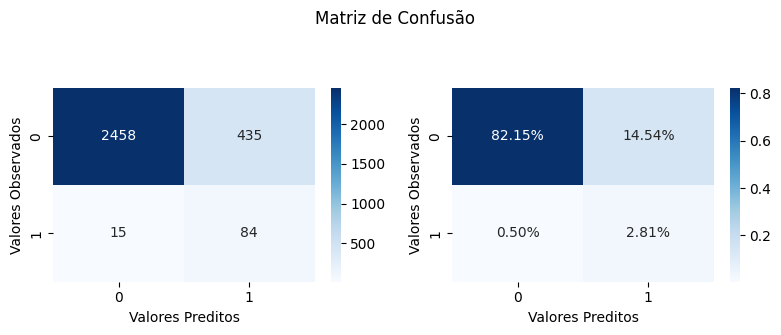

In [ ]:
# criando mapa de calor
matriz_confusao(y_test, y_pred1)

Das 99 falhas o modelo conseguiu identificar 84, mas marcou 435 com falhas máquinas que não apresentaram problemas. As métricas de interesse para nosso problema são `recall` (revocação) pois queremos identificar o máximo de falha possível e `f1_score` pois não podemos marcar com falhas máquinas que não apresentem problemas.

In [ ]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      2893
           1       0.16      0.85      0.27        99

    accuracy                           0.85      2992
   macro avg       0.58      0.85      0.59      2992
weighted avg       0.97      0.85      0.89      2992



Podemos observar as métricas de interesse em cada categoria de y.

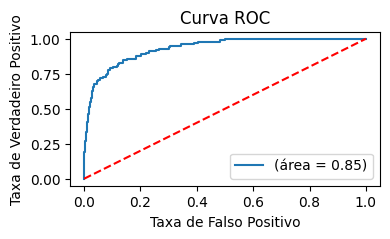

In [ ]:
# curva ROC
curva_roc(y_test, y_pred1, clf1)

Random Forest

Agora que temos um modelo base, vamos tentar obter resultados melhores.

In [ ]:
# instanciando algoritmo
model3 = RandomForestClassifier(class_weight='balanced', random_state=42)

# criando valores para os hiperparametros
params3 = {'n_estimators':[5,10,25,50,100],
           'criterion':['gini', 'entropy', 'log_loss'],
           'max_features':['sqrt', 'log2'],
           'max_depth':[2,5,10]}

clf3 = RandomizedSearchCV(model3, params3, cv=5, random_state=42, scoring=['recall','f1'], refit='recall')
search3 = clf3.fit(X_train, y_train)

In [ ]:
# verificando melhores hiperparâmetros
search3.best_params_

{'n_estimators': 100,
 'max_features': 'sqrt',
 'max_depth': 5,
 'criterion': 'entropy'}

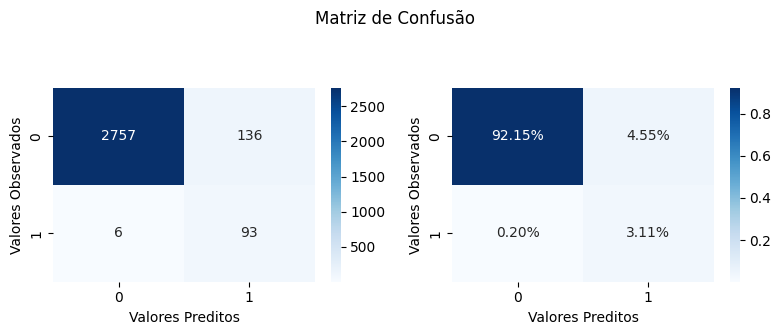

In [ ]:
clf3 = search3.best_estimator_

# fazendo previsões no conjunto de teste
y_pred3 = search3.predict(X_test)

# criando mapa de calor
matriz_confusao(y_test, y_pred3)

Este modelo não identificou apenas 6 máquinas problemáticas, e a quantidade de falsos positivos caiu muito, indicando que este é um modelo melhor.

In [ ]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2893
           1       0.41      0.94      0.57        99

    accuracy                           0.95      2992
   macro avg       0.70      0.95      0.77      2992
weighted avg       0.98      0.95      0.96      2992



Comparando com o modelo anterior podemos ver que tanto recall quanto f1 subiram muito.

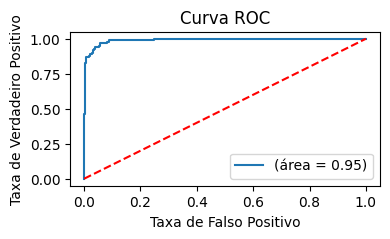

In [ ]:
curva_roc(y_test, y_pred3, clf3)

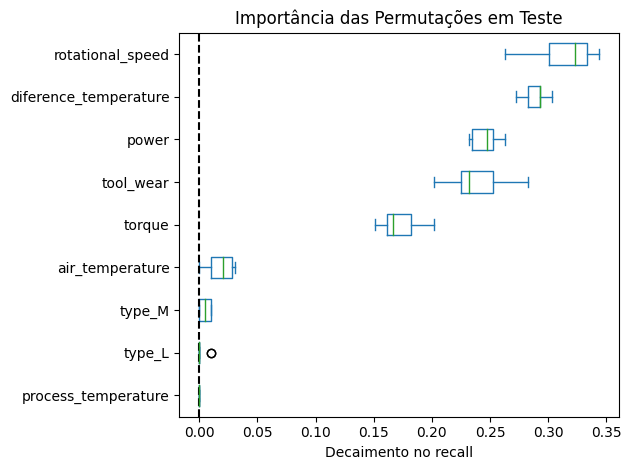

In [ ]:
# calculando a importância das variáveis
result = permutation_importance(
    clf3, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='recall'
)

sorted_importances_idx = result['importances_mean'].argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Importância das Permutações em Teste")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decaimento no recall")
ax.figure.tight_layout()

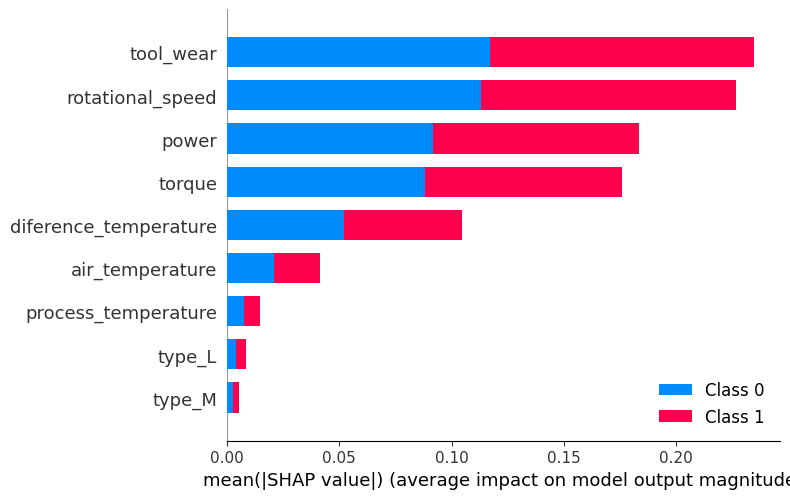

In [ ]:
# usando SHAP
explainer = shap.TreeExplainer(clf3)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

Agora, usaremos outra técnica para tentar melhorar nossos modelos. Vamos balancear as classes na variável y. Há várias formas de fazer isso como, por exemplo, criando dados sintéticos, adotaremos essa abordagem a seguir.

In [ ]:
# criando dados sintéticos para balancear as classes y
from imblearn.over_sampling import SMOTE
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [ ]:
# verificando que de fato está balanceado
y_train.value_counts()

0    6750
1    6750
Name: target, dtype: int64

Agora vamos novamente treinar um modelo de regressão logística.

In [ ]:
# instanciando algoritmo
model10 = LogisticRegression(random_state=42)

# criando valores para os hiperparametros
params10 = {'penalty':['l1', 'l2', 'elasticnet', None],
           'C':[1.5,1,0.5,0.01]}

clf10 = RandomizedSearchCV(model10, params10, cv=5, random_state=42, scoring=['recall','f1'], refit='recall')
search10 = clf10.fit(X_train, y_train)

In [ ]:
# melhores hiperparâmetros
search10.best_params_

{'penalty': None, 'C': 0.5}

In [ ]:
clf10 = search10.best_estimator_

# fazendo previsões
y_pred10 = search10.predict(X_test)

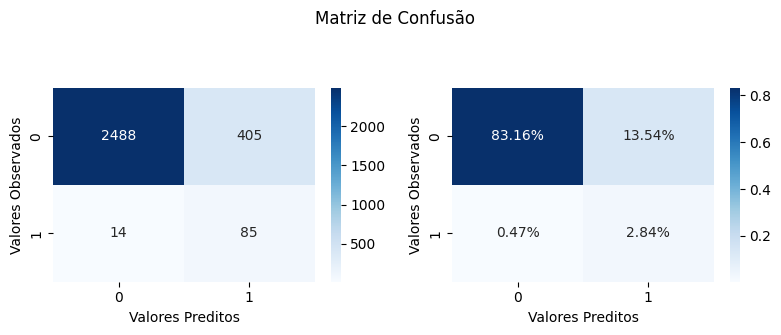

In [ ]:
# criando matriz de confusão
matriz_confusao(y_test, y_pred10)

In [ ]:
print(classification_report(y_test, y_pred10))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2893
           1       0.17      0.86      0.29        99

    accuracy                           0.86      2992
   macro avg       0.58      0.86      0.61      2992
weighted avg       0.97      0.86      0.90      2992



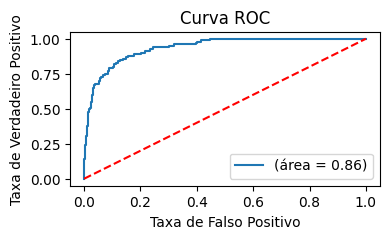

In [ ]:
curva_roc(y_test, y_pred10, search10)

As métricas acima mostram que praticamente não houve diferença em relação ao primeiro modelo de regressão logística criado.

Random Forest

In [ ]:
# instanciando algoritmo
model11 = RandomForestClassifier(random_state=42)

# criando valores para os hiperparametros
params11 = {'n_estimators':[5,10,25,50,100],
           'criterion':['gini', 'entropy', 'log_loss'],
           'max_features':['sqrt', 'log2'],
           'max_depth':[2,10,20,30,50]}

clf11 = RandomizedSearchCV(model11, params11, cv=5, random_state=42, scoring=['recall','f1'], refit='recall')
search11 = clf11.fit(X_train, y_train)

In [ ]:
# melhores hiperparâmetros
search11.best_params_

{'n_estimators': 25,
 'max_features': 'sqrt',
 'max_depth': 30,
 'criterion': 'entropy'}

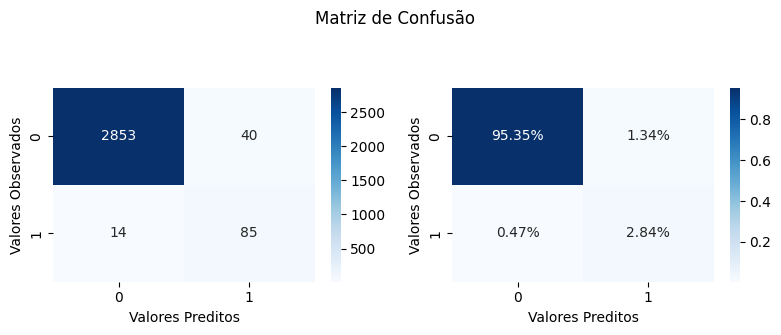

In [ ]:
clf11 = search11.best_estimator_

# fazendo previsões
y_pred11 = search11.predict(X_test)

# criando mapa de calor
matriz_confusao(y_test, y_pred11)

In [ ]:
print(f'Recall do primeiro modelo de árvore: {recall_score(y_test, y_pred3)}')
print(f'Recall do segundo modelo de árvore: {recall_score(y_test, y_pred11)}')

Recall do primeiro modelo de árvore: 0.9393939393939394
Recall do segundo modelo de árvore: 0.8585858585858586


Neste caso o número de falsos positivos caiu em relação ao outro modelo de árvores, mas houve um aumento falsos negativos. De modo geral, houve diminuição do recall.

In [ ]:
print(classification_report(y_test, y_pred11))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2893
           1       0.68      0.86      0.76        99

    accuracy                           0.98      2992
   macro avg       0.84      0.92      0.87      2992
weighted avg       0.98      0.98      0.98      2992



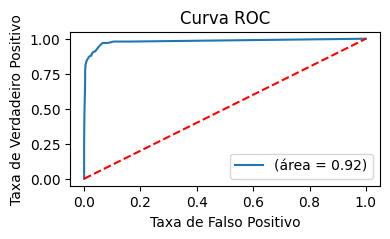

In [ ]:
curva_roc(y_test, y_pred11, clf11)

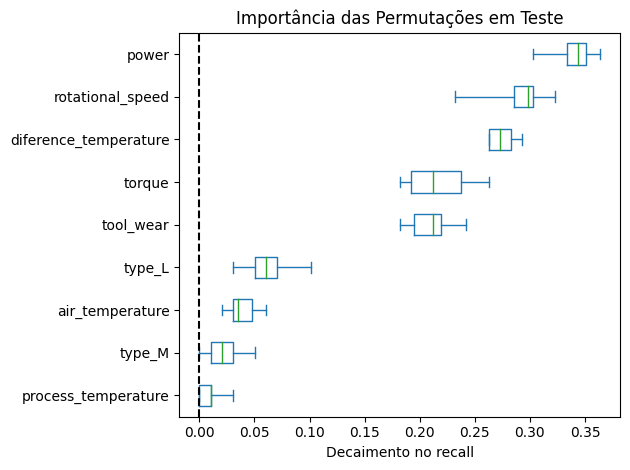

In [ ]:
# calculando a importância das variáveis
result = permutation_importance(
    clf11, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring='recall'
)

sorted_importances_idx = result['importances_mean'].argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Importância das Permutações em Teste")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decaimento no recall")
ax.figure.tight_layout()

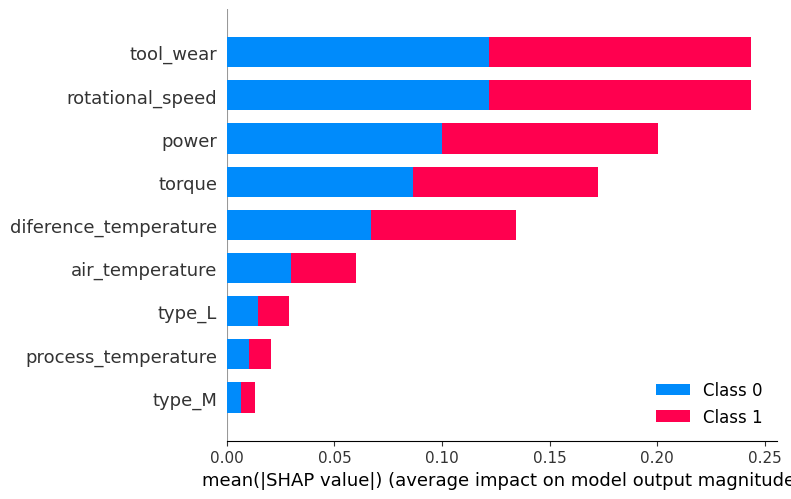

In [ ]:
# usando SHAP
explainer = shap.TreeExplainer(clf11)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

É interessante notar que a variável `diference_temperature` realmente é relevante para o modelo.

Rede Neural usando Keras

Agora tentaremos um modelo do tipo rede neural.

In [ ]:
!pip install ann_visualizer -q

  Preparing metadata (setup.py) ... done


In [ ]:
# importando layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from ann_visualizer.visualize import ann_viz

In [ ]:
# convertendo variável alvo em categórica
y_train_keras = to_categorical(y_train)
y_test_keras = to_categorical(y_test)

In [ ]:
# criando arquitetura da rede
keras_clas = Sequential()
keras_clas.add(Dense(9, activation='relu', input_dim=9))
keras_clas.add(Dense(5, activation='relu'))
keras_clas.add(Dense(2, activation='softmax'))

In [ ]:
# compilando o modelo
keras_clas.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=2, verbose=1)

In [ ]:
# treinando o modelo
history = keras_clas.fit(X_train, y_train_keras,
                         epochs=100, callbacks=[callback],
                         verbose=False)

Epoch 71: early stopping


In [ ]:
# fazendo previsões e calculando classification_report
y_pred = (keras_clas.predict(X_test) >= 0.5).astype(int)[:,1]
print(classification_report(y_test_keras[:,1], y_pred, zero_division=0))

94/94 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      2893
         1.0       0.35      0.89      0.50        99

    accuracy                           0.94      2992
   macro avg       0.67      0.92      0.74      2992
weighted avg       0.97      0.94      0.95      2992



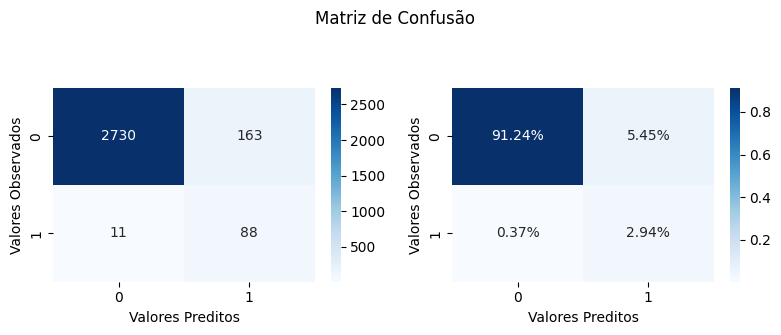

In [ ]:
matriz_confusao(y_test_keras[:,1], y_pred)

A rede neural teve um desempenho semelhante à floresta aleatória.

94/94 [==============================] - 0s 2ms/step


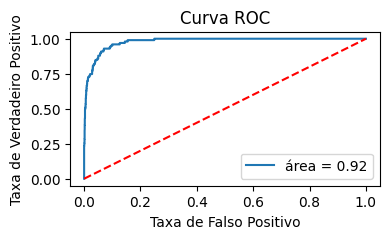

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test_keras[:,1], keras_clas.predict(X_test)[:,1])
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, label=f'área = {round(logit_roc_auc, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right");

In [ ]:
ann_viz(keras_clas, view=True, filename="network.png", title='Arquitetura')

# Conclusões

Com base nos resultados encontrados de cada modelo, a escolha final deve ser realizada a depender do custo/prejuízo de uma máquina quebrar e/ou ter que parar a produção para dar manutenção. Vamos considerar que o melhor modelo é o segundo de árvore e vamos salvá-lo para uso futuro.

In [ ]:
pickle.dump(clf3, open('clf_model.sav', 'wb'))